In [31]:
%matplotlib inline
%load_ext heat

In [30]:
#%%heat
import multiprocessing as mp
from IPython.display import Image
from copy import copy,deepcopy
from numpy import pi
import numpy as np
from qutip import *
from qutip.qip.operations import *
from qutip.qip.circuit import QubitCircuit, Gate
import time
from itertools import combinations
import matplotlib as mpl
import matplotlib.pyplot as plt



def qu(gnum,n): # pick the unitary from the gate set #error    
    if gnum<2*n+1:
        if gnum%2==0:
            g_t= Gate("T",int((gnum-1)//2)) 
        else:
            g_t= Gate("SNOT", int((gnum-1)//2))
    elif gnum<2*n+n+1:
        g_t= Gate("CNOT",int((gnum-2*n)%n),int((gnum-2*n+1)%n))
    return g_t

def quc(x,n): # generate the given quantum circuit
    qc= QubitCircuit(n)
    for i in range(len(x)):
        if x[i]!=0:
            qc.add_gate(qu(x[i], n))
    prop = qc.propagators()
    return gate_sequence_product(prop).full()
    

#may be faster to apply inverse i.e. loop over numbers gmax**r in base gmax
# def list_circuits(gmax,r):# list the circuits
#     def list_c(*arrays): 
#         grid = np.meshgrid(*arrays)        
#         coord_list = [entry.ravel() for entry in grid]
#         points = np.vstack(coord_list).T
#         return points
#     aa = np.arange(gmax)
#     return list_c(*r*[np.arange(gmax)])

# below is time inefficient but memory efficient
# not optimal 28.8 vs 15.7

def base_conv(cirnum,gmax,r): 
    xx= np.zeros(r)
    num=np.copy(cirnum)
    for i in range(r): 
        xx[i]= num%gmax
        num//=gmax
    return xx

def bi(ii,n):
    bix = np.zeros(n)
    for i in range(n): 
        bix[i]= ii%2
        ii//=2
    return(bix)

def list_povm(n):
    l_povms=[]
    for qbits in range(n+1): 
            for pv in combinations(np.arange(n),n-qbits):
                pov = np.zeros(n)
                for iden in  range(len(pv)):
                    pov[pv[iden]]= 1
                povm = gene_povm(pov,n)
                l_povms.append(np.diag(povm))
    return(l_povms)
                

# below is time inefficient but memory efficient
#removed since, it is less optimal 4.67s vs 3.54s


def gene_povm(gnp,n): 
    pv = np.zeros(2**n)
    b = gnp
    pv[0]= 1
    for j in range(len(b)): 
        if b[j]==1:
            pv[2**j:2**(j+1)]= pv[:2**j]
    return(np.diag(pv))                 

def trqrho(q,rho):
    trq= 0
    trq+= np.sum(np.diag(q)*np.diag(rho),)
    return(trq)

def tr(q): 
    return(np.sum(q))

def opt_povm(r,rho,gmax,n,lst_povm,cnum):
    H=2**n
    if cnum==0:
        counter = 0
        prevtr = 2**n
        thistr = 0
        for povme in range(len(lst_povm)):
            povm= lst_povm[povme]
            trqq = trqrho(rho,povm)
            thistr = tr(povm)
            if trqq>=eta:
                counter+=1
                if thistr<H:
                    H= np.copy(thistr)
            if (thistr!=prevtr) and counter==0:
                prevtr=np.copy(thistr)
                break
            else: 
                prevtr=np.copy(thistr)
    else:
        bc = base_conv(cnum,gmax,r)
        U = quc(bc,n)
        sigma = U@rho@U.conj().T # use of einsum may make it faster? need to make this step faster? sparce?
        counter=0
        prevtr = 2**n
        thistr = 0
        for povme in range(len(lst_povm)):
            povm= lst_povm[povme]
            trqq = trqrho(sigma,povm)
            thistr = tr(povm)
            if trqq>=eta:
                counter+=1
                if thistr<H:
                    H= np.copy(thistr)
            if (thistr!=prevtr) and counter==0:
                prevtr=np.copy(thistr)
                break
            else: 
                prevtr=np.copy(thistr)
    return(H)

    
def H_eep(r,eta,rho,gmax,n):
    ndg_list=[]        
    for cnum in range(0,gmax**r):# this lists out for unique gates
        bc=base_conv(cnum,gmax,r)
        if np.all(bc[bc !=0]-bc[:len(bc[bc !=0])]==0):
            ndg_list = np.append(ndg_list,cnum)
    tt = np.nditer(ndg_list)
    lst_povm = list_povm(n)
    nprocs = mp.cpu_count()
    pool=mp.Pool(processes=nprocs)
    H_array= pool.starmap(opt_povm,[(r,rho,gmax,n,lst_povm,circuitnum) for circuitnum in tt])
    pool.close()
    H_min=min(H_array)
    print("effective entropy for eta="+str(eta)+" and r="+str(r) +" is "+ str(np.log(H_min)/np.log(2)))
    return(np.log(H_min)/np.log(2))

def H_ee(r,eta,rho,gmax,n):
    ndg_list=[]
    tt=0
        
    for cnum in range(0,gmax**r):# this lists out for unique gates
        bc=base_conv(cnum,gmax,r)
        if np.all(bc[bc !=0]-bc[:len(bc[bc !=0])]==0):
            ndg_list = np.append(ndg_list,cnum)
            
    lst_povm = list_povm(n)
    circi=0
    povmi=0
    H=2**n
    for cnum in np.nditer(ndg_list):
        if cnum==0:
            counter = 0
            prevtr = 2**n
            thistr = 0
            for povme in range(len(lst_povm)):
                povm= lst_povm[povme]
                trqq = trqrho(rho,povm)
                thistr = tr(povm)
                if trqq>=eta:
                    counter+=1
                    if thistr<H:
                        circi = np.copy(cnum)
                        povmi= povme
                        H= np.copy(thistr)
                if (thistr!=prevtr) and counter==0:
                    prevtr=np.copy(thistr)
                    break
                else: 
                    prevtr=np.copy(thistr)
        else:
            bc = base_conv(cnum,gmax,r)
            U = quc(bc,n)
            sigma = U@rho@U.conj().T # use of einsum may make it faster? need to make this step faster? sparce?
            counter = 0
            prevtr = 2**n
            thistr = 0
            for povme in range(len(lst_povm)):
                povm= lst_povm[povme]
                trqq = trqrho(sigma,povm)
                thistr = tr(povm)
                if trqq>=eta:
                    counter+=1
                    if thistr<H:
                        circi = np.copy(cnum)
                        povmi = povme
                        H= np.copy(thistr)
                if (thistr!=prevtr) and counter==0:
                    
                    prevtr=np.copy(thistr)
                    break
                else: 
                    prevtr=np.copy(thistr)

    print("effective entropy for eta="+str(eta)+" and r="+str(r) +" is "+ str(np.log(H)/np.log(2)))
    print(povmi)
    print(circi)
    return(np.log(H)/np.log(2))

In [10]:
# All the inputs are in this box 

# system specific data
n = 4 # number of qubits
gmax= 1+2*n+n #number of unique gates in the universal gate set [2*n 1-qubit gates, n CNOT gates]
# Need to change qu() if this is changed

# process specific

eta = 0.8 # success rate? 
# define rho below this
x = np.random.rand(2**n,2**n)
rho= x@x.transpose()
rho = rho/np.trace(rho)
#H_ee(r,eta,rho,gmax,n)
np.savetxt("rh.txt",rho)

In [23]:
eta = 0.825
r = 4
%time H_eep(r,eta,rho,gmax,n)

effective entropy for eta=0.825 and r=4 is 2.0
CPU times: user 919 ms, sys: 27.4 ms, total: 946 ms
Wall time: 13 s


2.0

In [28]:
eta = 0.80 
rr = np.zeros((8,2))
for i in range(len(rr)):
    r= i
    rho = np.loadtxt("rh.txt")
    print(np.shape(rho))
    rr[i,0]=i
    rr[i,1]= H_eep(r,eta,rho,gmax,n)
    np.savetxt('r.txt',rr)

np.savetxt('r.txt',rr)
    
    
    

(16, 16)
effective entropy for eta=0.8 and r=0 is 4.0
(16, 16)
effective entropy for eta=0.8 and r=1 is 3.0
(16, 16)
effective entropy for eta=0.8 and r=2 is 2.0
(16, 16)
effective entropy for eta=0.8 and r=3 is 1.0
(16, 16)
effective entropy for eta=0.8 and r=4 is 1.0
(16, 16)
effective entropy for eta=0.8 and r=5 is 1.0
(16, 16)
effective entropy for eta=0.8 and r=6 is 1.0
(16, 16)


KeyboardInterrupt: 

In [29]:
etan = np.zeros((8,2))
x = np.linspace(0.78,0.95,len(etan))
r = 5
for i in range(len(etan)):
    eta = np.copy(x[i])
    rho = np.loadtxt("rh.txt")
    etan[i,0]=np.copy(x[i])
    etan[i,1]= H_eep(r,eta,rho,gmax,n)
    np.savetxt("et.txt",etan)
np.savetxt("et.txt",etan)
    

effective entropy for eta=0.78 and r=5 is 0.0
effective entropy for eta=0.8042857142857143 and r=5 is 1.0
effective entropy for eta=0.8285714285714286 and r=5 is 2.0
effective entropy for eta=0.8528571428571429 and r=5 is 3.0
effective entropy for eta=0.8771428571428571 and r=5 is 3.0
effective entropy for eta=0.9014285714285714 and r=5 is 4.0
effective entropy for eta=0.9257142857142857 and r=5 is 4.0
effective entropy for eta=0.95 and r=5 is 4.0


<IPython.core.display.Javascript object>


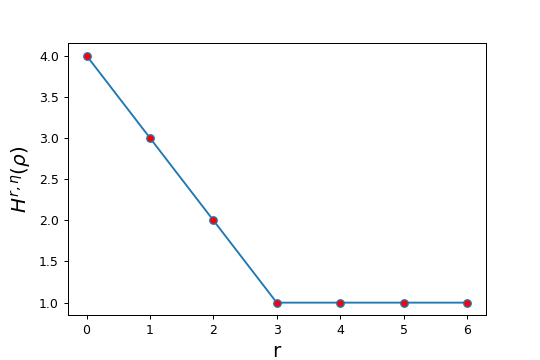

In [45]:
%matplotlib notebook
plt.figure(1, figsize=(6, 4))
x= np.loadtxt('r.txt')
plt.plot(x[:7,0],x[:7,1], marker= 'o',markerfacecolor='red')
plt.xlabel(r'r',fontsize=16)
plt.ylabel(r'$H^{r,\eta}(\rho)$',fontsize=16)
plt.show()

<IPython.core.display.Javascript object>


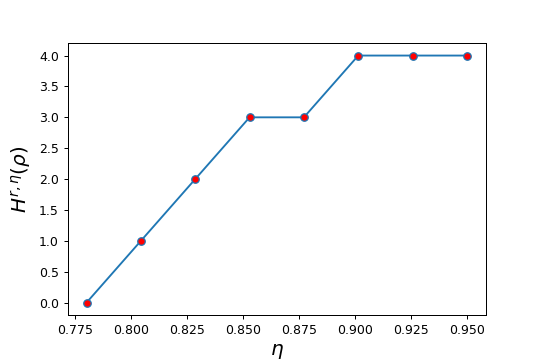

In [46]:
%matplotlib notebook
x= np.loadtxt('et.txt')
plt.plot(x[:,0],x[:,1],marker='o',markerfacecolor='red')
plt.xlabel(r'$\eta$',fontsize=16)
plt.ylabel(r'$H^{r,\eta}(\rho)$',fontsize=16)
plt.show()

In [8]:
def fn1(a,b):
    if a>=b:
        return(0)
def fn2(a,b):
    if a>b or a==b:
        return(0)



In [9]:
a = 10
b = 20
%timeit fn1(a,b)
%timeit fn2(a,b)


10000000 loops, best of 5: 77 ns per loop
10000000 loops, best of 5: 88.9 ns per loop


In [10]:
print(4*np.log(16)/np.log(10))

4.816479930623698


In [ ]:
print(povmi)#873
print(circi)
U = quc(base_conv(circi,gmax,r),n)
print(np.diag(U@rho@U.conj()))
print(np.sum(np.diag(U@rho@U.conj())))